Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


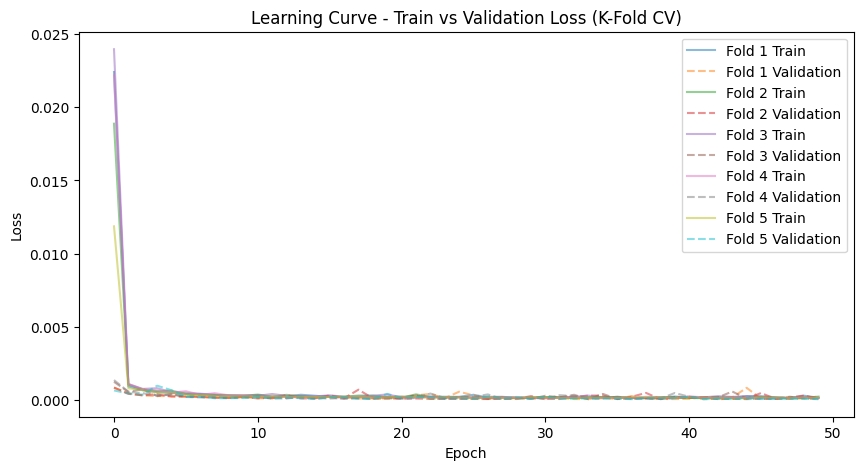

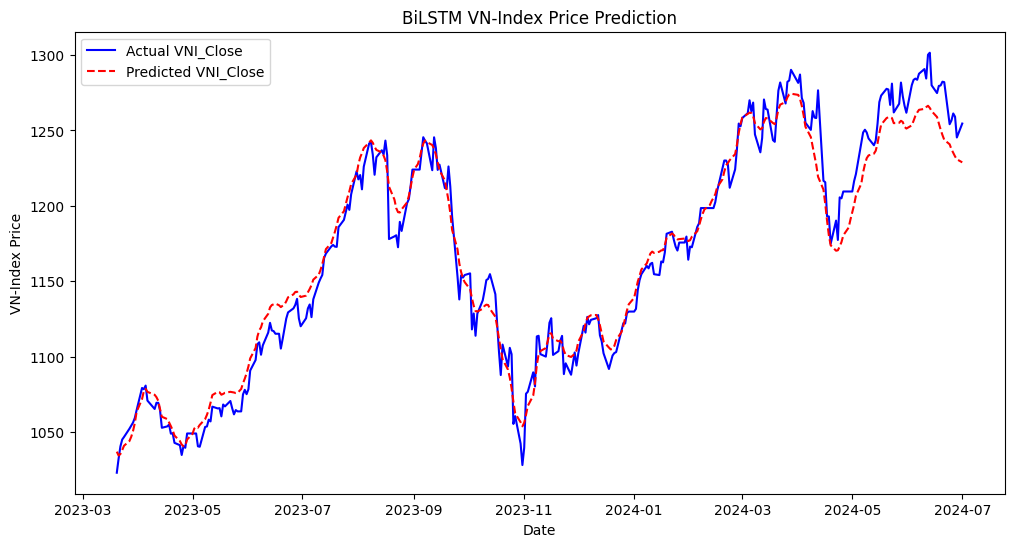

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# Đọc dữ liệu
file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\data.csv"
df = pd.read_csv(file_path)

# Chuyển đổi cột Date thành datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = 'VNI_Close price'
feature_cols = [col for col in df.columns if col != target_col]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Hàm tạo sequences
def create_sequences(data, target_col, seq_length=30):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu
seq_length = 30
X, y = create_sequences(df_scaled, target_col, seq_length)

# Chia train/val/test (80% train, 10% val, 10% test)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Định nghĩa mô hình BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size * 2, 1)  # *2 do bidirectional

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        out = self.fc(bilstm_out[:, -1, :])  # Lấy output cuối cùng của cả 2 hướng
        return out.squeeze()

# Cross Validation (K-Fold)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_train_losses = []
fold_val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}/{k_folds}")

    # Chia dữ liệu theo Fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    train_loader_fold = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=32, shuffle=False)

    # Khởi tạo mô hình mới cho mỗi fold
    model = BiLSTMModel(input_size=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Huấn luyện trong 50 epochs
    num_epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader_fold:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader_fold))

        # Validation Loss
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader_fold:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                y_pred = model(batch_X)
                loss = criterion(y_pred, batch_y)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss / len(val_loader_fold))

    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)

# Vẽ Learning Curve
plt.figure(figsize=(10, 5))
for i in range(k_folds):
    plt.plot(fold_train_losses[i], label=f"Fold {i+1} Train", linestyle='solid', alpha=0.5)
    plt.plot(fold_val_losses[i], label=f"Fold {i+1} Validation", linestyle='dashed', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve - Train vs Validation Loss (K-Fold CV)")
plt.legend()
plt.show()

# Dự đoán trên tập test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False):
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())  
        actuals.extend(batch_y.numpy())

# Chuyển từ numpy array sang dạng ma trận cột
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

# Inverse transform để đưa về giá trị thực tế
scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])  
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("BiLSTM VN-Index Price Prediction")
plt.show()


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Test MAE: 10.41
Test MSE: 179.05
Test RMSE: 13.38


In [ ]:
from sklearn.metrics import mean_squared_error
import copy

# Dự đoán ban đầu trên tập test (để lấy baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Tính Feature Importance bằng cách hoán đổi từng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # Xáo trộn feature thứ i

    # Dự đoán lại
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # Tính RMSE sau khi hoán đổi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature nào làm tăng RMSE nhiều là quan trọng hơn
    feature_importance[feature] = importance_score

# Sắp xếp theo độ quan trọng giảm dần
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Δ RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # Đảo ngược để feature quan trọng nhất ở trên cùng
plt.show()
